In [1]:
import numpy as np
import pandas as pd
import scipy.io as sio
import mne
from mne.datasets import fetch_fsaverage

mat_file = 'erf.mat'
erf_data = sio.loadmat(mat_file)
spike_rate = erf_data['erf_all'][0][0][2][0]  # Spike rate 
hfo_rate = erf_data['erf_all'][0][0][4][0]  # HFO rate 
electrodes = erf_data['erf_all'][0][0][1][0]  # names

localization_file = 'iEEG_localization.xlsx'
localization_df = pd.read_excel(localization_file, sheet_name='p200309') 
localization_df.columns = ['Electrode', 'X', 'Y', 'Z', 'X_2', 'Y_2', 'Z_2', 'Region'] 
region_data = localization_df[['Electrode', 'Region']].set_index('Electrode')['Region'].to_dict()

In [2]:
# saving coordinates to a dictionary
electrode_coords = {}
for index, row in localization_df.iterrows():
    electrode_coords[row['Electrode']] = (row['X_2'], row['Y_2'], row['Z_2'])

In [3]:
spike_data = [] # a list of dictionaries with electrodes coords and their spike_rate

for i, electrode in enumerate(electrodes):
    electrode_name = electrode[0].split('-')[0]  # Access the string and split it
    
    if electrode_name in electrode_coords:
        coords = electrode_coords[electrode_name]
        spike_data.append({
            'Electrode': electrode_name,
            'X': coords[0],
            'Y': coords[1],
            'Z': coords[2],
            'Spike Rate': spike_rate[i]
        })
    else:
        print(f"Electrode {electrode_name} not found in coordinates")

spike_df = pd.DataFrame(spike_data)
print("Spike DataFrame:")
print(spike_df)

Spike DataFrame:
   Electrode     X     Y     Z  Spike Rate
0       1TP1 -16.7  -1.4 -36.8       36.16
1       1TP2 -21.7  -1.6 -37.8       27.54
2       1TP3 -26.5  -1.6 -38.3        8.68
3       1TP4 -32.0  -1.7 -38.3        2.64
4       1TP5 -37.3  -1.6 -37.2        1.24
..       ...   ...   ...   ...         ...
84     12CR3  13.6  32.9  10.8        4.74
85     12CR4  18.5  33.3  12.7        2.36
86     12CR5  24.0  34.3  15.5        0.18
87     12CR6  29.1  35.6  18.0        0.10
88     12CR7  34.1  36.9  20.1        0.00

[89 rows x 5 columns]


In [4]:
# finding the electrode with the highest spike activity

max_spike_electrode = spike_df.loc[spike_df['Spike Rate'].idxmax()]

print(f"Electrode with max spike rate: {max_spike_electrode['Electrode']}")
print(max_spike_electrode['Spike Rate'])
print(f"Localization: X={max_spike_electrode['X']}, Y={max_spike_electrode['Y']}, Z={max_spike_electrode['Z']}")

Electrode with max spike rate: 7TP2
40.1
Localization: X=15.2, Y=-6.6, Z=-26.6


In [5]:
# paths to mne datasets - sample sEEG and FreeSurfer's fsaverage subject
# which is in MNI space
misc_path = mne.datasets.misc.data_path()
sample_path = mne.datasets.sample.data_path()
subjects_dir = sample_path / "subjects"

# use mne-python's fsaverage data
fetch_fsaverage(subjects_dir=subjects_dir, verbose=True)  # downloads if needed

0 files missing from root.txt in /Users/diana/mne_data/MNE-sample-data/subjects
0 files missing from bem.txt in /Users/diana/mne_data/MNE-sample-data/subjects/fsaverage


MNEPosixPath('/Users/diana/mne_data/MNE-sample-data/subjects/fsaverage')

In [6]:
ch_names=list(electrode_coords.keys())
coords_mni_ras = np.array(localization_df[['X_2','Y_2','Z_2']])

montage = mne.channels.make_dig_montage(
    ch_pos=dict(zip(ch_names, coords_mni_ras/1000.0)),
    coord_frame='head'  # because MNI is in MRI space
)

info = mne.create_info(ch_names=ch_names, ch_types='seeg', sfreq=1000)
info.set_montage(montage)

<Info | 8 non-empty values
 bads: []
 ch_names: 1TP1, 1TP2, 1TP3, 1TP4, 1TP5, 1TP6, 1TP7, 1TP8, 2B1, 2B2, 2B3, ...
 chs: 114 sEEG
 custom_ref_applied: False
 dig: 117 items (3 Cardinal, 114 EEG)
 highpass: 0.0 Hz
 lowpass: 500.0 Hz
 meas_date: unspecified
 nchan: 114
 projs: []
 sfreq: 1000.0 Hz
>

In [7]:
info

<Info | 8 non-empty values
 bads: []
 ch_names: 1TP1, 1TP2, 1TP3, 1TP4, 1TP5, 1TP6, 1TP7, 1TP8, 2B1, 2B2, 2B3, ...
 chs: 114 sEEG
 custom_ref_applied: False
 dig: 117 items (3 Cardinal, 114 EEG)
 highpass: 0.0 Hz
 lowpass: 500.0 Hz
 meas_date: unspecified
 nchan: 114
 projs: []
 sfreq: 1000.0 Hz
>

In [8]:
identity_trans = mne.transforms.Transform('head', 'mri')  # head → mri
identity_trans['trans'] = np.eye(4)

view_kwargs = dict(azimuth=105, elevation=100, focalpoint=(0, 0, -15))

brain = mne.viz.Brain(
    "fsaverage",
    subjects_dir=subjects_dir,
    cortex="low_contrast",
    alpha=0.25,
    background="white",
    # surf = 'inflated'
)

brain.add_sensors(info, trans=identity_trans)
brain.add_head(alpha=0.25, color="tan")
brain.show_view(distance=400, **view_kwargs)

Using pyvistaqt 3d backend.
Channel types::	seeg: 114
Using fsaverage-head-dense.fif for head surface.
    1 BEM surfaces found
    Reading a surface...
[done]
    1 BEM surfaces read


In [9]:
# get standard fsaverage volume (5mm grid) source space
fname_src = subjects_dir / "fsaverage" / "bem" / "fsaverage-vol-5-src.fif"
vol_src = mne.read_source_spaces(fname_src)

aver_src = vol_src

    Reading a source space...
    [done]
    1 source spaces read


Using surface: /Users/diana/mne_data/MNE-sample-data/subjects/fsaverage/bem/inner_skull.surf
Using surface: /Users/diana/mne_data/MNE-sample-data/subjects/fsaverage/bem/outer_skull.surf
Using surface: /Users/diana/mne_data/MNE-sample-data/subjects/fsaverage/bem/outer_skin.surf


/Users/diana/Library/jupyterlab-desktop/jlab_server/lib/python3.12/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


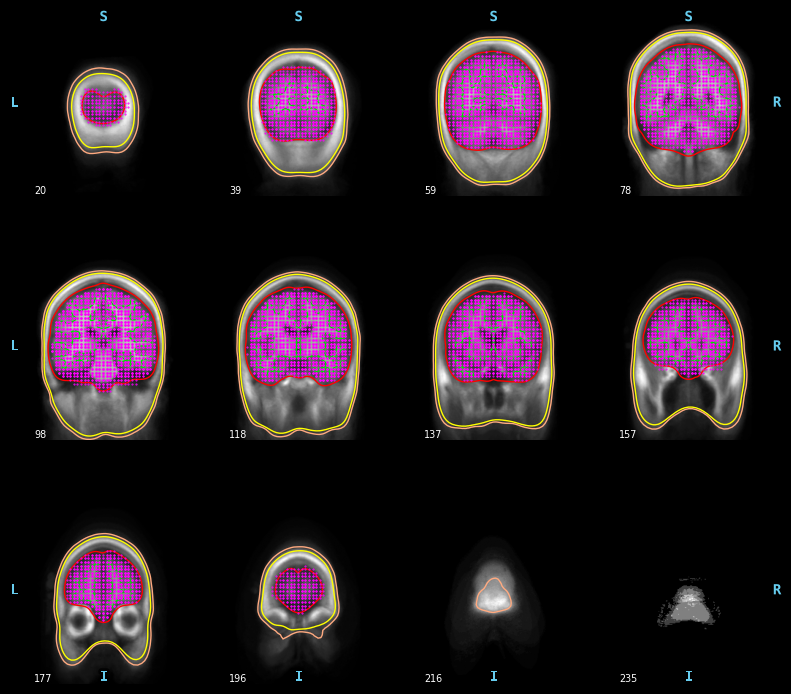

In [10]:
fig = mne.viz.plot_bem(subject='fsaverage', subjects_dir=subjects_dir,
                 brain_surfaces='white', orientation='coronal', src=aver_src)

In [11]:
import numpy as np
import nibabel as nib
from scipy.spatial import cKDTree

In [12]:
# electrode MNI coordinates (the highest spike rate)
mni_coords_mm = np.array([[15.2, -6.6, -26.6]]) / 1000

# all source points from the source space
all_rr = np.concatenate([s['rr'][s['inuse'].astype(bool)] for s in vol_src])

tree = cKDTree(all_rr)
dist, idx = tree.query(mni_coords_mm) # the index of the closest source point

In [13]:
def find_closest(coords, tree):
    mni_coords_mm = np.array([coords]) # coords is a list of x y z
    dist, idx = tree.query(mni_coords_mm) # the index of the closest source point
    return idx

all_rr = np.concatenate([s['rr'][s['inuse'].astype(bool)] for s in vol_src])
tree = cKDTree(all_rr)

In [14]:
coordinates = [[x / 1000, y / 1000, z / 1000] for x, y, z in zip(spike_df.X.values, spike_df.Y.values, spike_df.Z.values)]
spike_rates = spike_df["Spike Rate"].values
src_coords = []
rates = dict()

for electrode, rate in zip(coordinates, spike_rates):
    src_id = find_closest(electrode, tree)
    src_coord = all_rr[src_id]
    if str(src_id) in rates:
        rates[str(src_id)].append(rate)
    else:
        rates[str(src_id)] = [rate]
    src_coords.append(src_coord)  

rates_ = dict([(src_id, sum(rates)/len(rates)) for src_id, rates in rates.items()])

In [15]:
all_rr.shape

(14629, 3)

In [22]:
all_rr_mm = all_rr 
source_coords_mm = all_rr_mm[idx]

In [23]:
source_coords_mm

array([[ 0.015, -0.005, -0.025]])

In [24]:
mni_coords_mm 

array([[ 0.0152, -0.0066, -0.0266]])

In [16]:
# localised sources 

brain = mne.viz.Brain(
    "fsaverage",
    subjects_dir=subjects_dir,
    cortex="low_contrast",
    alpha=0.25,
    background="white"
)

for source_coord in src_coords:
    brain.add_foci(
        source_coord * 1000,
        coords_as_verts=False,
        hemi='vol',
        color='red',
        scale_factor=0.5
    )

brain.show()

QGestureManager::deliverEvent: could not find the target for gesture


In [17]:
n_sources = all_rr.shape[0]
data = np.zeros((n_sources, 100))
for idx in rates.keys():
    idx_ = int(idx.replace('[', '').replace(']', ''))
    data[idx_] = np.array([rates_[idx]] * 100)

vertices = [np.arange(n_sources)]

In [18]:
idxs = [int(x.replace('[', '').replace(']', '')) for x in rates.keys()]

In [100]:
rates_tresh = dict()
rates_tresh_ = dict()
for key, value in rates.items():
    if value[0] / 40.1 > 0.2:
        rates_tresh[key] = [value[0] / 40.1 * 3] # normalisation + multipled by 3 as otherwise they're just super bleak 
        rates_tresh_[key] = value[0] / 40.1 * 3
    else:
        rates_tresh[key] = [0.0]
        rates_tresh_[key] = 0.0
    '''
    if value[0] >= 20:
        rates_tresh[key] = value[0]
        rates_tresh_[key] = value[0]
    else:
        rates_tresh[key] = [0.0]
        rates_tresh_[key] = 0.0
    rates_tresh[key] = [value[0] / 40.1]
    rates_tresh_[key] = value[0] / 40.1
    '''

In [20]:
unique_sorted_indices = np.array(sorted(idxs))
unique_spike_values = [rates_tresh_[f'[{idx}]'] for idx in unique_sorted_indices]
# Создаем данные для VolSourceEstimate
correct_vertices = np.array([vol_src[0]['vertno'][x] for x in sorted(idxs)])
vertices = [correct_vertices]  # Используем уникальные отсортированные индексы
data = np.array(unique_spike_values)[:, np.newaxis]  # Приведение к форме (n_vertices, n_times)

# Проверяем размерность и корректность
print(f"Data shape: {data.shape}, Vertices: {vertices}")

Data shape: (88, 1), Vertices: [array([ 9778,  9779,  9780, 11046, 11047, 11048, 11062, 11063, 11064,
       11068, 12156, 12186, 12187, 12188, 12216, 12217, 12218, 12247,
       12248, 12264, 12265, 12266, 12267, 12268, 12269, 12270, 12304,
       12330, 12331, 12332, 13614, 13615, 13616, 15997, 15998, 15999,
       16000, 17279, 17280, 17281, 17282, 17283, 18518, 18519, 18521,
       18523, 18524, 18525, 18526, 19814, 22854, 22888, 23613, 23614,
       24105, 24106, 24135, 24136, 24137, 24166, 24167, 24176, 24177,
       24871, 24872, 24873, 24889, 24890, 24891, 24892, 24893, 24894,
       24902, 24903, 24928, 24930, 24931, 25259, 25260, 25261, 25465,
       25466, 26545, 26577, 27861, 27862, 27863, 29147])]


In [21]:
vol_stc = mne.VolSourceEstimate(
    data=data,
    vertices=vertices,
    tmin=0,
    tstep=1,
    subject="fsaverage"
)

In [22]:
vol_stc

<VolSourceEstimate | 88 vertices, subject : fsaverage, tmin : 0.0 (ms), tmax : 0.0 (ms), tstep : 1000.0 (ms), data shape : (88, 1), ~2 kB>

In [23]:
clim = dict(kind="value", lims=[0.5, 0.7, 0.95])

brain = vol_stc.plot_3d(
    src=vol_src,
    subjects_dir=subjects_dir,
    view_layout="horizontal",
    views=["axial", "coronal", "sagittal"],
    size=(800, 300),
    show_traces=0.4,
    clim=clim,
    add_data_kwargs=dict(colorbar_kwargs=dict(label_font_size=8)),
)

## Forward Model

In [24]:
src_vol = mne.read_source_spaces(subjects_dir / "fsaverage" / "bem" / "fsaverage-vol-5-src.fif")
bem = mne.read_bem_solution(subjects_dir / "fsaverage" / "bem" / "fsaverage-5120-5120-5120-bem-sol.fif")

    Reading a source space...
    [done]
    1 source spaces read
Loading surfaces...

Loading the solution matrix...

Three-layer model surfaces loaded.
Loaded linear collocation BEM solution from /Users/diana/mne_data/MNE-sample-data/subjects/fsaverage/bem/fsaverage-5120-5120-5120-bem-sol.fif


In [25]:
src_vol[0]['vertno'].shape

(14629,)

In [26]:
montage = mne.channels.make_standard_montage('standard_1020')
ch_names = montage.ch_names[:64]
info = mne.create_info(ch_names=ch_names, sfreq=1000, ch_types='eeg')
info.set_montage(montage)

<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fpz, Fp2, AF9, AF7, AF5, AF3, AF1, AFz, AF2, AF4, AF6, AF8, ...
 chs: 64 EEG
 custom_ref_applied: False
 dig: 67 items (3 Cardinal, 64 EEG)
 highpass: 0.0 Hz
 lowpass: 500.0 Hz
 meas_date: unspecified
 nchan: 64
 projs: []
 sfreq: 1000.0 Hz
>

In [27]:
fwd_vol = mne.make_forward_solution(
    info=info,
    trans='fsaverage',  
    src=src_vol,
    bem=bem,
    eeg=True,
    meg=False
)

Source space          : <SourceSpaces: [<volume, shape=(33, 39, 34), n_used=14629>] MRI (surface RAS) coords, subject 'fsaverage', ~75.3 MB>
MRI -> head transform : /Users/diana/Library/jupyterlab-desktop/jlab_server/lib/python3.12/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 1 source spaces a total of 14629 active source locations

Coordinate transformation: MRI (surface RAS) -> head
    0.999994 0.003552 0.000202      -1.76 mm
    -0.003558 0.998389 0.056626      31.09 mm
    -0.000001 -0.056626 0.998395      39.60 mm
    0.000000 0.000000 0.000000       1.00

Read  64 EEG channels from info
Head coordinate coil definitions created.
Source spaces are now in head coordinates.

Employing the head->MRI coordinate transform with the BEM model.
BEM model instance of ConductorModel is now set up

Sourc

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.



Finished.


In [28]:
fwd_vol

EEG,64
Source space,Volume with 14629 grid points
Source orientation,Free


In [29]:
fwd_vol['sol']['data'].shape

(64, 43887)

In [30]:
43887 / 3

14629.0

In [31]:
src_vol[0]['vertno'].shape

(14629,)

In [32]:
gain = fwd_vol['sol']['data']
n_sources = gain.shape[1] // 3
gain_fixed = np.zeros((gain.shape[0], n_sources))

for i in range(n_sources):
    gx = gain[:, 3*i + 0]
    gy = gain[:, 3*i + 1]
    gz = gain[:, 3*i + 2]
    gain_fixed[:, i] = np.sqrt(gx**2 + gy**2 + gz**2)

In [33]:
gain_fixed.shape

(64, 14629)

In [101]:
unique_sorted_indices = np.array(sorted(src_vol[0]['vertno']))
unique_spike_values = []
for idx in unique_sorted_indices:
    if f'[{idx}]' in rates_tresh_.keys():
        unique_spike_values.append(rates_tresh_[f'[{idx}]'])
    else:
        unique_spike_values.append(0)
# Создаем данные для VolSourceEstimate
correct_vertices_ = np.array([vol_src[0]['vertno'][x] for x in sorted(idxs)])
vertices_ = [correct_vertices]  # Используем уникальные отсортированные индексы
data_ = np.array(unique_spike_values)[:, np.newaxis]  # Приведение к форме (n_vertices, n_times)

In [102]:
source_data = data_ #* (10 ** (-8))

In [73]:
rates_tresh_

{'[1442]': 0.9017456359102243,
 '[964]': 0.6867830423940149,
 '[963]': 0.2164588528678304,
 '[962]': 0.0658354114713217,
 '[1438]': 0.030922693266832918,
 '[1437]': 0.010972568578553615,
 '[1436]': 0.01596009975062344,
 '[1848]': 0.4718204488778055,
 '[1873]': 0.513715710723192,
 '[1872]': 0.22044887780548628,
 '[1871]': 0.00798004987531172,
 '[1896]': 0.011471321695760598,
 '[1895]': 0.007481296758104738,
 '[1894]': 0.006483790523690773,
 '[1919]': 0.010972568578553615,
 '[1918]': 0.0014962593516209474,
 '[6055]': 0.20149625935162094,
 '[5253]': 0.40997506234413966,
 '[5252]': 0.11521197007481297,
 '[5251]': 0.34014962593516207,
 '[5250]': 0.008478802992518703,
 '[5248]': 0.0,
 '[5246]': 0.000997506234413965,
 '[5245]': 0.0004987531172069825,
 '[9151]': 0.01795511221945137,
 '[9150]': 0.06932668329177057,
 '[9148]': 0.007481296758104738,
 '[9120]': 0.0004987531172069825,
 '[9119]': 0.0,
 '[9118]': 0.0,
 '[9117]': 0.00199501246882793,
 '[9116]': 0.0004987531172069825,
 '[9115]': 0.0049

In [103]:
sensor_data = gain_fixed @ source_data

In [108]:
sensor_data

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [104]:
evoked = mne.EvokedArray(sensor_data, info=info, tmin=0)

In [40]:
from mne import make_ad_hoc_cov
noise_cov = make_ad_hoc_cov(info)

In [41]:
inverse_operator = mne.minimum_norm.make_inverse_operator(info, fwd_vol, noise_cov=noise_cov)

Computing inverse operator with 64 channels.
    64 out of 64 channels remain after picking
Selected 64 channels
Creating the depth weighting matrix...
    64 EEG channels
    limit = 14630/14629 = 3.882442
    scale = 61579.2 exp = 0.8
Whitening the forward solution.
Computing rank from covariance with rank=None
    Using tolerance 5.7e-18 (2.2e-16 eps * 64 dim * 0.0004  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.


/var/folders/s_/hsjplx7j0zqcp5bdmqbv5hcm0000gn/T/ipykernel_56620/2053878520.py:1: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  inverse_operator = mne.minimum_norm.make_inverse_operator(info, fwd_vol, noise_cov=noise_cov)
/var/folders/s_/hsjplx7j0zqcp5bdmqbv5hcm0000gn/T/ipykernel_56620/2053878520.py:1: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  inverse_operator = mne.minimum_norm.make_inverse_operator(info, fwd_vol, noise_cov=noise_cov)


    largest singular value = 4.72127
    scaling factor to adjust the trace = 5.96068e+22 (nchan = 64 nzero = 0)


In [105]:
snr = 3.0
lambda2 = 1.0 / snr ** 2
evoked.set_eeg_reference(projection=True)
stc_cortex = mne.minimum_norm.apply_inverse(evoked, inverse_operator, lambda2=lambda2, method='dSPM')

EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    The projection vectors do not apply to these channels.
    Created the whitener using a noise covariance matrix with rank 64 (0 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Applying inverse operator to ""...
    Picked 64 channels from the data
    Computing inverse...
    Eigenleads need to be weighted ...
    Computing residual...
    Explained   nan% variance
    Combining the current components...
    dSPM...
[done]


/Users/diana/Library/jupyterlab-desktop/jlab_server/lib/python3.12/site-packages/mne/minimum_norm/inverse.py:1041: RuntimeWarning: invalid value encountered in scalar divide
  var_exp = 1 - ((res * res.conj()).sum().real / (data * data.conj()).sum().real)


In [106]:
stc_cortex.data

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

In [107]:
brain = stc_cortex.plot_3d(
    src=vol_src,
    subjects_dir=subjects_dir,
    view_layout="horizontal",
    views=["axial", "coronal", "sagittal"],
    size=(800, 300),
    show_traces=0.4,
    clim=clim,
    add_data_kwargs=dict(colorbar_kwargs=dict(label_font_size=8)),
)

## MEG IZ

In [27]:
import pickle

src_file = '/Users/diana/Documents/cases/A0R0/forward_model/src.pckl'

with open(src_file, 'rb') as f:
    src = pickle.load(f)
    
mne_coords = np.concatenate([s['rr'][s['inuse'].astype(bool)] for s in src])

In [28]:
vol_mne = mne_coords[8194::]

In [29]:
trans=mne.read_trans('/Users/diana/Documents/cases/A0R0/forward_model/checked_visually_trans.fif')

In [30]:
identity_trans = mne.transforms.Transform('head', 'mri')  # head → mri
identity_trans['trans'] = np.eye(4)

In [31]:
mni_coords = mne.head_to_mni(mne_coords, 'A0R0', trans, subjects_dir='Freesurfer')

In [32]:
mni_vol = mne.head_to_mri(vol_mne, 'A0R0', trans, subjects_dir='Freesurfer')

In [33]:
iz_meg_file = '/Users/diana/Documents/sEEG/A0R0_pred.out'

In [34]:
activity = np.loadtxt(iz_meg_file)
data = activity[:, np.newaxis]

In [35]:
vol_activity = activity[8194::]

In [36]:
src_coords = []

for source, rate in zip(mni_coords/1000, activity):
    src_id = find_closest(source, tree)
    src_coord = all_rr[src_id]
    if rate == 1 and src_id.tolist()[0] not in src_coords:
        src_coords.append(src_id.tolist()[0])
correct_vertices = np.array([vol_src[0]['vertno'][x] for x in sorted(src_coords)])
vertices = [correct_vertices]  # Используем уникальные отсортированные индексы

In [37]:
src_vol = []

for source, rate in zip(mni_vol/1000, vol_activity):
    src_id = find_closest(source, tree)
    src_coord = all_rr[src_id]
    if rate == 1 and src_id.tolist()[0] not in src_vol:
        src_vol.append(src_id.tolist()[0])
correct_vertices_vol = np.array([vol_src[0]['vertno'][x] for x in sorted(src_vol)])
vertices_vol = [correct_vertices_vol]  # Используем уникальные отсортированные индексы

In [38]:
data = np.ones((vertices[0].shape[0],1))

In [39]:
iz_stc = mne.VolSourceEstimate(
    data=data,
    vertices=vertices,
    tmin=0,
    tstep=1,
    subject="fsaverage"
)

In [40]:
iz_stc

<VolSourceEstimate | 509 vertices, subject : fsaverage, tmin : 0.0 (ms), tmax : 0.0 (ms), tstep : 1000.0 (ms), data shape : (509, 1), ~8 kB>

In [41]:
clim = dict(kind="value", lims=[0.5, 0.7, 0.95])

brain = iz_stc.plot_3d(
    src=vol_src,
    subjects_dir=subjects_dir,
    view_layout="horizontal",
    views=["axial", "coronal", "sagittal"],
    size=(800, 300),
    show_traces=0.4,
    clim=clim,
    add_data_kwargs=dict(colorbar_kwargs=dict(label_font_size=8)),
)